<a href="https://colab.research.google.com/github/soupsoupr/StrokeSegmentation/blob/main/test_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nibabel as nib
import os
# Set the file path to the directory containing the DWI data files
file_path = '/content/drive/MyDrive/ISLES/dataset-ISLES22^public^unzipped^version'

for example_case in range(1,11): # for the first 10 data from ISLES22
    # Set images path.
    dwi_path = os.path.join(file_path, 'rawdata', 'sub-strokecase{}'.format("%04d" %example_case), 'ses-0001',
                            'sub-strokecase{}_ses-0001_dwi.nii.gz'.format("%04d" %example_case))
    mask_path = dwi_path.replace('rawdata', 'derivatives').replace('dwi', 'msk')

# Load image data.
dwi_data = []
mask_data = []

dwi_data = nib.load(dwi_path).get_fdata()
mask_data = nib.load(mask_path).get_fdata()

In [3]:
import numpy as np
import cv2

# Duplicate both dwi and label data into two new lists for future process
data_paths = []
mask_paths = []

for i in dwi_data:
    data_paths.append(i)

for i in mask_data:
    mask_paths.append(i)

# Define framework

In [4]:
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [5]:
class CustomDataset(Dataset):
    def __init__ (self, img, mask, transformer):
        self.img = img
        self.mask = mask
        self.transformer = transformer

    def __len__ (self):
        return len(self.img)

    def __getitem__ (self, index):
        img = self.img[index]
        mask = self.mask[index]

        img_open = Image.fromarray(img)
        img_tensor = self.transformer(img_open)

        mask_open = Image.fromarray(mask)
        mask_tensor = self.transformer(mask_open)

        mask_tensor = torch.squeeze(mask_tensor).type(torch.long)

        return img_tensor, mask_tensor

In [6]:
train_transformer = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

test_transformer = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [7]:
sample = 100
train_data = data_paths[:sample]
train_label = mask_paths[:sample]

test_data = data_paths[sample:]
test_label = mask_paths[sample:]

In [8]:
# Train and test sets initalization
train_data = CustomDataset(train_data, train_label, train_transformer)
test_data = CustomDataset(test_data, test_label, test_transformer)

In [9]:
# Train and test set data loaders initalization
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

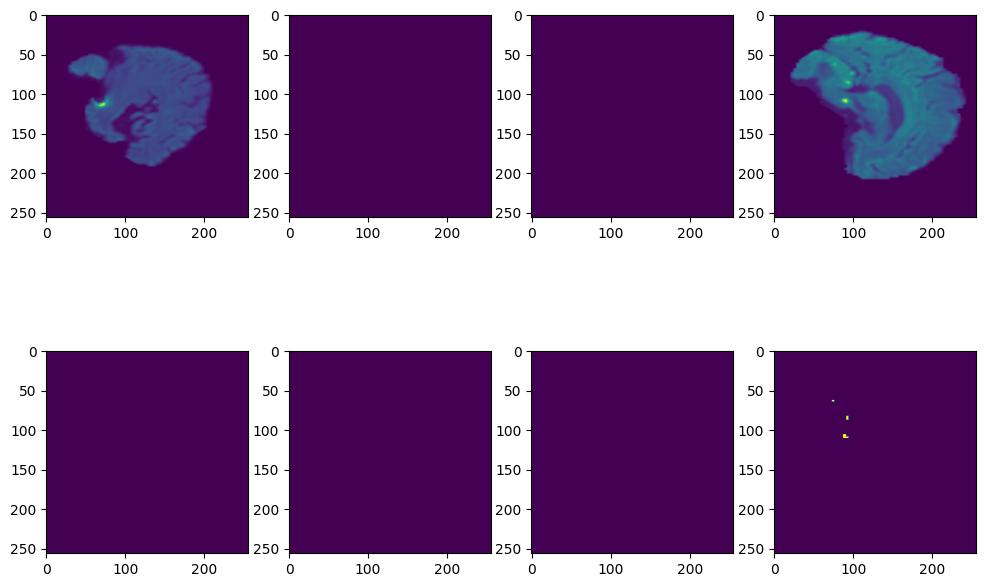

In [10]:
data, label = next(iter(train_loader))
plt.figure(figsize=(12,8))
for i, (data, label) in enumerate(zip(data[:4], label[:4])):
    data = data.permute(1,2,0).numpy()
    label = label.numpy()
    plt.subplot(2,4,i+1)
    plt.imshow(data)
    plt.subplot(2,4,i+5)
    plt.imshow(label)

# U-net down convolution

In [30]:
class Encoder(nn.Module):
    def __init__ (self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x, if_pool=True):
        if if_pool:
            x = self.maxpool(x)
        x = self.conv_relu(x)
        return x

# U-net up convolution

In [27]:
class Decoder(nn.Module):
    def __init__ (self, channels):
        super(Decoder, self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(2*channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upconv_relu = nn.Sequential(
            nn.ConvTranspose2d(channels, channels//2, kernel_size=3, stride=3, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x



# U-net constrution for segmentation

In [28]:
class Unet(nn.Module):
    def __init__ (self):
        super(Unet, self).__init__()
        self.encoder1 = Encoder(3, 64)
        self.encoder2 = Encoder(64, 128)
        self.encoder3 = Encoder(128, 256)
        self.encoder4 = Encoder(256, 512)
        self.encoder5 = Encoder(512, 1024)

        self.upconv_relu = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder1 = Decoder(512)
        self.decoder2 = Decoder(256)
        self.decoder3 = Decoder(128)

        self.convDouble = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x, if_pool=False)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x5 = self.encoder5(x4)

        x5 = self.upconv_relu(x5)

        x5 = torch.cat([x4,x5], dim=1)
        x5 = self.decoder1(x5)
        x5 = torch.cat([x3,x5], dim=1)
        x5 = self.decoder2(x5)
        x5 = torch.cat([x2,x5], dim=1)
        x5 = self.decoder3(x5)
        x5 = torch.cat([x1,x5], dim=1)

        x5 = self.convDouble(x5)
        x5 = self.last(x5)

        return x5

In [31]:
model = Unet()
model

Unet(
  (encoder1): Encoder(
    (conv_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): Encoder(
    (conv_relu): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): Encoder(
    (conv_relu): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inpl

In [ ]:
img, label = next(iter(train_loader))
pred = model(img)
pred.shape